# PFN feature analysis

Analyze the high-level features ($\Phi_n$) of the PFN using the SHAP algorithm.

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow import keras
from matplotlib import pyplot as plt

2024-01-21 08:08:41.555877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 08:09:03.223202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
task_name = "axion2"

## 1. Compute high-level features using saved model

In [3]:
# ~1 min
import sys
sys.path.append("../..")

from utils import data_dir, model_dir

In [4]:
# 2 sec
model = keras.models.load_model(f"{model_dir}/{task_name}_pfn")

2024-01-21 08:10:28.661870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-01-21 08:10:28.663620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9804 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-01-21 08:10:28.665000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9804 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-01-21 08:10:28.666456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9804 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [5]:
## LOAD DATA
particles = ["pi0", "gamma", task_name]
clouds = []
for particle in particles:
    print(f"Loading 10% of data for particle {particle}...")
    clouds.append(np.load(f"{data_dir}/processed/{particle}_cloud.npy")[::10])
clouds = np.vstack(clouds)
print(f"clouds.shape: {clouds.shape}")

Loading 10% of data for particle pi0...
Loading 10% of data for particle gamma...
Loading 10% of data for particle axion2...
clouds.shape: (30000, 960, 4)


In [6]:
cut_layer = "Sigma"

In [7]:
Phi_model = keras.models.Model(inputs=model.inputs, outputs=model.get_layer(cut_layer).output)

In [8]:
F_model = keras.models.Model(inputs=model.get_layer(cut_layer).output, outputs=model.output)

In [11]:
Phi_outputs = Phi_model.predict(clouds)

938/938 [==============================] - 3s 3ms/step


In [12]:
print(f"Shape of Phi_outputs:", Phi_outputs.shape)

Shape of Phi_outputs: (30000, 128)


In [13]:
N = Phi_outputs.shape[0] // 3

preds = np.argmax(F_model(Phi_outputs), axis=1)
truth = np.array((0,)*N + (1,)*N + (2,)*N)
print(preds[:10])
print(truth[:10])
print(f"Accuracy: {(preds == truth).sum() / len(preds) * 100:.2f}%")

[0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0]
Accuracy: 99.60%


# Part 2: Apply SHAP algorithm

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Multioutput%20Regression%20SHAP.html

In [14]:
# ~2 min
import shap

In [15]:
sample_Phi_outputs = shap.sample(Phi_outputs, 50)

In [16]:
explainer = shap.KernelExplainer(
    model=F_model.predict,
    data=sample_Phi_outputs,
    link="identity"  # Not entirely sure what this does
)

2/2 [==============================] - 0s 3ms/step


In [17]:
shap_values = explainer.shap_values(X=sample_Phi_outputs)

  0%|          | 0/50 [00:00<?, ?it/s]

3547/3547 [==============================] - 4s 1ms/step


In [20]:
print(len(shap_values))
print(shap_values[0].shape)

3
(50, 128)


In [21]:
shap.initjs()

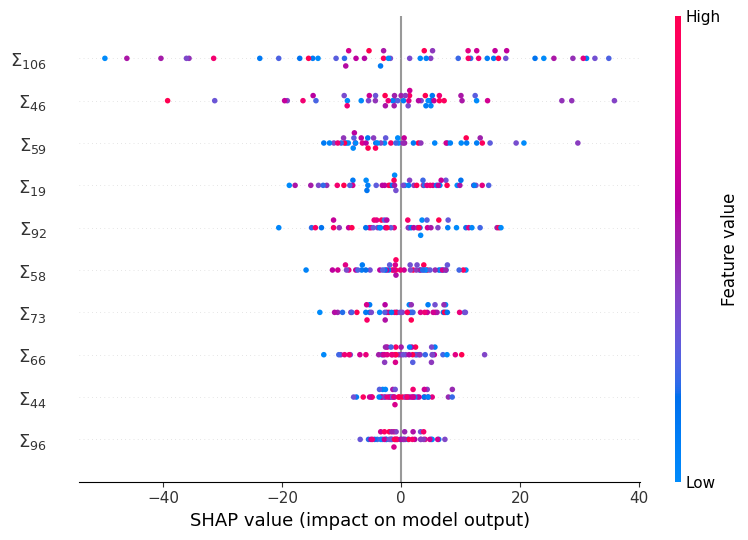

In [22]:
shap.summary_plot(
    shap_values=shap_values[0],
    features=Phi_outputs[:50],
    feature_names=[f"$\Sigma_{{{i}}}$" for i in range(Phi_outputs.shape[1])],
    max_display=10
)

In [24]:
np.save(f"./pfn_layer_outputs/{task_name}_PFN_SHAP_values.npy", np.array(shap_values))